In [7]:
import freud
import gsd
import hoomd
import gsd.pygsd
import gsd.hoomd
import signac
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
from scipy import misc, ndimage, interpolate
from scipy.signal import argrelextrema as argex
from os.path import exists
from os import makedirs
import os
import time
from pylab import cm
hoomd.context.initialize("")

In [2]:
ptb7_path= "/home/gwenwhite/cmelab/ptb7-itic/ptb7-project/"
project = signac.get_project(ptb7_path)

In [3]:
state_dict= {"size": "small",
             "density": 0.6,
             "kT_reduced": 1.0,
             "molecule": "PTB7_5mer_smiles",
             "process": "quench"}

job_list= project.find_jobs(state_dict)
for job in job_list:
    job_path = job.fn('trajectory.gsd')

In [4]:
def atom_type_pos(snap, atom_type):
    if not isinstance(atom_type, list):
        atom_type = [atom_type]
    positions = []
    for atom in atom_type:
        indices = np.where(snap.particles.typeid == snap.particles.types.index(atom))
        positions.append(snap.particles.position[indices])
    return np.concatenate(positions)

## Diffraction Pattern

In [1]:
f = gsd.pygsd.GSDFile(open(job_path, "rb"))
t = gsd.hoomd.HOOMDTrajectory(f)
last_frame = [-1]
frame = len(t)
snap = hoomd.data.gsd_snapshot(job_path, frame-1)
points = snap.particles.position
box = freud.Box.from_box(snap.box)
dp = freud.diffraction.DiffractionPattern(grid_size=1024,
                                  output_size=1024)
dp.compute((box, points), view_orientation=np.array([1,0,0,0]))

NameError: name 'gsd' is not defined

### Diffraction pattern with select atom types

In [6]:
total_atoms = 41+53+1+4+4
print(total_atoms)
# we're doing united atom--so our total atoms is 
total_atoms-=53
print(total_atoms)

103
50


In [7]:
with gsd.hoomd.open(name=job_path, mode='rb') as t:
    snap = t[-1]

In [8]:
# here are all the atom types in our system
snap.particles.types

['cc', 'cd', 'ca', 'os', 'c3', 'ss', 'c', 'o', 'f']

In [9]:
# here is the list of particles by typeid 
# e.g. ["cc", "cd", "cc"] --> [0,1,0]
print(len(snap.particles.typeid))
print(len(snap.particles.typeid)/(total_atoms*10))
snap.particles.typeid

50000
100.0


array([0, 1, 2, ..., 4, 2, 5], dtype=uint32)

In [10]:
atomtype = "ss"
points = snap.particles.position[
    snap.particles.typeid == snap.particles.types.index(atomtype)
]

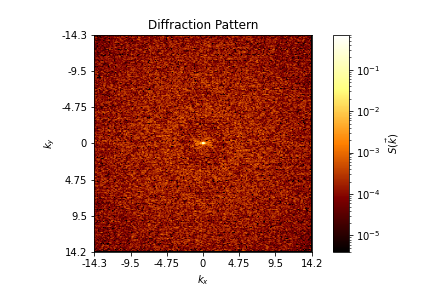

<Figure size 432x288 with 0 Axes>

In [11]:
box = freud.Box.from_box(snap.configuration.box)

dp = freud.diffraction.DiffractionPattern(
    grid_size=1024,
    output_size=1024
)
dp.compute((box, points), view_orientation=np.array([1,0,0,0]))

## Diffraction pattern that calculates static structure

In [12]:
 def prep_sq(self,p):
        y, x = numpy.indices(p.shape)
        n = len(x)/2 -1
        center = arr([n,n])
        rmax = n
        bin_n = int(numpy.ceil(rmax/self.bin_w))
        bins = [self.bin_w*i for i in range(bin_n+1)]
        self.bins=arr(bins)
        self.asq = numpy.zeros((len(bins),))
        r = numpy.hypot(x - center[1], y - center[0]).flatten() #radii, constant for a single zoom
        i = numpy.argsort(r.flat) #array index into p corresponding to r
        r_sort = r.flat[i] #sorted radius indices
        self.idx = i[r_sort<=n] #only keep indices corresponding to radii below cutoff
        self.idbig = i[r_sort>n]
        r_sort = r_sort[r_sort <= n] #only keep radii below cutoff
        bindicies = numpy.digitize(r_sort,bins, right=True)
        bindicies = numpy.insert(bindicies,len(bindicies),bindicies[-1]+1)
        jumps = bindicies[1:]-bindicies[:-1]
        jumps = numpy.where(jumps)[0]
        nb = jumps[1:]-jumps[:-1]
        self.jumps = jumps
        self.nb = nb
        self.sq_xaxis = 2*numpy.pi*self.bins/(self.zoom*numpy.max(self.box)*self.length_scale)

def structure_factor(self, p): 
        a_sort = p.flat[self.idx]
        cs = numpy.cumsum(a_sort,dtype=float)
        cs = cs[self.jumps]
        cs = cs[1:] - cs[:-1]
        cs /= self.nb
        cs = numpy.insert(cs,0,numpy.log10(self.top)) #if we're not taking log of dp, insert a 1.0 instead of 0
        self.asq+=cs
        return cs

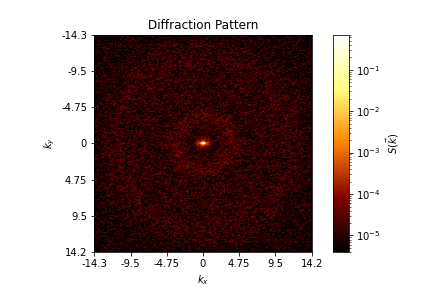

<Figure size 432x288 with 0 Axes>

In [13]:
f = gsd.pygsd.GSDFile(open(job_path, "rb"))
t = gsd.hoomd.HOOMDTrajectory(f)
last_frame = [-1]
frame = len(t)
snap = hoomd.data.gsd_snapshot(job_path, frame-1)
points = snap.particles.position
box = freud.Box.from_box(snap.box)
dp = freud.diffraction.DiffractionPattern(grid_size=1024,
                                  output_size=1024)
dp.compute((box, points), view_orientation=np.array([1,0,0,0]))